# Problem Set - Gaussian Processes 

In [1]:
# The modules we will be using in this problem set
import util, test # These are local modules please feel free to read through them
from importlib import reload
reload(util)
reload(test)
import numpy as np
import matplotlib.pyplot as plt

## Gaussian Processes##

In this problem set, you will gain a deeper understanding of how Gaussian processes work by building a small library for Gaussian regression and classification. If you are having serious problems with this assignment, please feel free to ask on Piazza or refer to [Gaussian Processes: A Quick Introduction](A Quick Intro To Gaussian Proccesses.pdf).

### Problems
1. [Part 1 - Overview](#Part-1---Overview)
  1. [Problem 1 (10 pts)](#Problem-1---Making-a-Simple-Kernal-%2810-pts%29)
  2. [Problem 2 (5 pts)](#Problem-2---Making-a-Periodic-Kernal-%285-pts%29)
2. [Part 2 - Regression](#Part-2---Regression)
3. [Part 3 - Classification](#Part-3---Classification)

# Part 1 - Overview

As covered in lecture, Gaussian Processes (GPs) allow us to infer entire functions from a set of observations without extensive initial parametrizing. The power of GPs lies in the covariance matrix $\Sigma$, which specifies the pairwise covariance between all of the points in your dataset. Knowing how a point is affected by all other points in the data allows us to adjust our beliefs about the shape of the underlying function as well as the uncertainty around this function every time a new observation is made.


In lecture, we explained that a GP is, loosely speaking, an extension of a multivariate Gaussian distribution. Instead of a finite-dimension vector, a GP describes the distribution of infinite-dimension vectors, aka continuous functions. A GP fully inherits Gaussian properties from the multivariate Gaussian, which is why -when we assume a zero mean, which we can easily do-  it is fully specified by a positive semi-definite covariance matrix $\Sigma$.


In a multivariate Gaussian, we can easily compute the pairwise covariance between variables, since they are in finite amount, by simply applying the following formula, where $x$ and $x'$ are variables with respective means $\mu_{x}$ and $\mu_{x'}$: $$ cov(x, x') = \frac{\sum_{i=1}^{n}(x_{i}-\mu_{x})(x'_{i}-\mu_{x'})}{n-1}$$


This formula fails for a GP, seeing how $n$ goes to $+\infty$. For this reason, we need to find a generalized similarity relation between any two points in the data in the form of a function. We call this function a *kernel*, and it is the building block that will allow us to specify any GP, and then use it for regression and classification exercises. 

## Problem 1 - Making a Simple Kernel (10 pts)
In the following problem, you will be designing a kernel for a dataset where your belief at a certain point is most affected by its neighbors. This behavior occurs everywhere in nature: when throwing a ball in the air, your most recent location will tell you the most information about where the ball will be next. 

The kernel you will implement below is the one we have focused on in our lecture:


$$ k(x, x') = \overbrace{\sigma_{f}^{2}}^{\text{prior covariance}}\cdot\hspace{2em}\exp\bigg[{\frac{-(x-x')^{2}}{{2l^{2}}}}\bigg] + \overbrace{\sigma_{n}^{2}}^{\text{measurement noise}}\cdot\hspace{2em}\delta(x, x')\,$$ where $$\delta(x_{i}, x_{j})= \begin{cases} 1 & \text{if}\ x_{i}=x{j} \\0 & \text{otherwise} \end{cases}$$


You can see clearly that the maximum allowed covariance will be $ \sigma_{f}^{2} + \sigma_{n}^{2}$. If $x \approx x′$, then $k(x, x′)$ approaches this maximum, meaning $f(x)$ is nearly perfectly correlated with $f(x′)$. This is good: for our function to look smooth, neighbours must be alike.

Now if $x$ is very distant from $x′$, we have instead $k(x,x′) \approx 0$, i.e. the two points cannot ‘see’ each other. So, for example, during interpolation at new $x$ values, distant observations will have negligible effect. 

How much effect this separation has will depend on the length parameter, $l$. You will see the effect of changing $l$ later on in the assignment.

In the following cell, please implement the `kernel()` function as per the equation above.

In [4]:
def kernel(x0, x1, params, sigma_n):
    diff = np.subtract.outer(x0, x1)
    value = params[0]**2 * np.exp( -0.5 * (1.0/params[1]**2) * diff**2)
    value[np.where(diff == 0.0)] += sigma_n
    return value

In [5]:
test.test_simple_kernel(kernel)

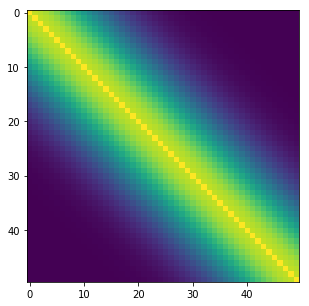

In [5]:
x = np.linspace(-5, 5, 50)
sigma_n = 0.1
params = [1, 2]
K = kernel(x, x, params, sigma_n)
util.visiualize_kernel(K)

## Problem 2 - Making a Periodic Kernel (5 pts)
In the previous part, we looked at a kernel for a dataset where distance to the point of interest was the heaviest contributing factor to the covariance. However, many datasets cannot be fully represented by such a relationship, such as periodic datasets. For instance, if you were looking to predict the temperature in July 2018, knowing the temperature in January 2018 would not tell you as much as the temperature in July 2017, even though January 2018 is closest to July 2018. In this following problem, you will implement a kernel that can accurately model periodic datasets. 

A periodic kernel will incorporate the distance kernel, because nearby points still affect your belief. You will be able to simply add a new term to your $k(x,x')$ from earlier in order to adjust your kernel to consider periodicity. 

Below is the formula for the periodic kernel:

$$ k(x, x') = {\sigma_{f}^{2}}\cdot\exp\bigg[{\frac{-(x-x')^{2}}{{2l^{2}}}}\bigg] + \overbrace{\exp\{-2\sin^2[\nu\pi(x-x')]\}}^{\text{periodic term}} +\sigma_{n}^{2}\cdot\delta(x, x') \,$$

where $\nu$ is the frequency of your periodic function. 

Note that in this case, $x$ and $x'$ can be distant from one another (July 2017 and July 2018) yet still 'see' each other: $ k(x, x') \neq 0$ when $x$ and $x'$ are very distant from one another.

In the following cell, please implement the `periodic_kernel()` function as per the equation above.

In [6]:
def periodic_kernel(x0, x1, params, sigma_n):
    diff = np.subtract.outer(x0, x1)
    value = params[0]**2 * np.exp( -0.5 * (1.0/params[1]**2) * diff**2)
    value += params[2]**2 * np.exp(-2 * np.sin(params[3]*diff)**2)
    value[np.where(diff == 0.0)] += sigma_n**2
    return value

In [7]:
test.test_periodic_kernel(periodic_kernel)

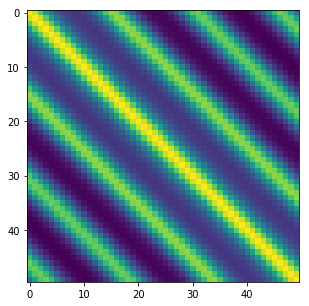

In [8]:
x = np.linspace(-5, 5, 50)
sigma_n = 0.1
params = [1, 2, 2, 1]
K = periodic_kernel(x, x, params, sigma_n)
util.visiualize_kernel(K)

# Part 2 - Regression

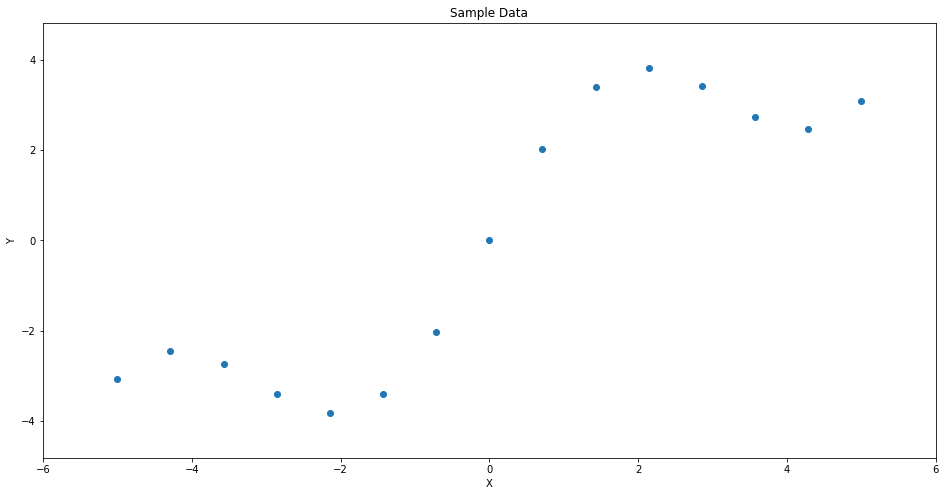

In [9]:
x, y = util.get_sample_data_1()
util.scatter_raw_data(x, y)

## Problem 3 - Getting the $\Sigma$ Matrix (5 pts)
You are now ready to build out the covariance matrix $\Sigma$ that you will use for the Gaussian regression. This matrix makes use of 3 different components, each built with your kernel function $k()$. Assuming you have $n$ points in your prior, and are looking to infer $m$ values,  these components are:


* $K$, the $n \times n$ covariance matrix of your prior: $K_{i,j} = k(x_{i},x_{j})$


$$ K=
\begin{bmatrix}
    k(x_{1},x_{1})       & k(x_{1},x_{2}) & k(x_{1},x_{3}) & \dots & k(x_{1},x_{n}) \\
    k(x_{2},x_{1})       & k(x_{2},x_{2}) & k(x_{2},x_{3}) & \dots & k(x_{2},x_{n}) \\
    k(x_{3},x_{1})       & k(x_{3},x_{2}) & k(x_{3},x_{3}) & \dots & k(x_{3},x_{n}) \\
    \hphantom{\ddots}  & \ddots& \ddots\\
    k(x_{n},x_{1})       & k(x_{n},x_{2}) & k(x_{n},x_{3}) & \dots & k(x_{n},x_{n}) \\
\end{bmatrix}$$


* $K_{*}$, the $m \times n$ matrix containing the kernel function evaluated between your $m$ points of interest $x'_{i}$ and each point in your prior: $K^{*}_{i,j} = k(x'_{i},x_{j})$


$$ K_{*}=
\begin{bmatrix}
    k(x'_{1},x_{1})       & k(x'_{1},x_{2}) & k(x'_{1},x_{3}) & \dots & k(x'_{1},x_{n}) \\
    \hphantom{\ddots}  & \ddots& \ddots\\
    k(x'_{m},x_{1})       & k(x'_{m},x_{2}) & k(x'_{m},x_{3}) & \dots & k(x'_{m},x_{n}) \\
\end{bmatrix}$$


* $K_{**}$, the $m \times m$ matrix containing the kernel function evaluated between your $m$ points of interest and themselves: $K^{**}_{i,j} = k(x'_{i},x'_{j})$


$$ K_{**}=
\begin{bmatrix}
    k(x'_{1},x'_{1})       & k(x'_{1},x'_{2}) & k(x'_{1},x'_{3}) & \dots & k(x'_{1},x'_{m}) \\
    \hphantom{\ddots}  & \ddots& \ddots\\
    k(x'_{m},x'_{1})       & k(x'_{m},x'_{2}) & k(x'_{m},x'_{3}) & \dots & k(x'_{m},x'_{m}) \\
\end{bmatrix}$$


With those 3 matrices, you can build $\Sigma$ as follows:
$$ \Sigma =
\begin{bmatrix}
K & K_{*}^{\intercal} \\ K_{*} & K_{**}\\
\end{bmatrix}$$


In the cell below, please implement `get_Ks()` by writing a function that returns 3 items: $K$, $K_{*}$, $K_{**}$

In [10]:
def get_Ks(x_new, x, kernel, theta):
    K = kernel(x, x, theta[:-1], theta[-1]) # K
    KS = kernel(x_new, x, theta[:-1], theta[-1]) # K*
    KSS = kernel(x_new, x_new, theta[:-1], theta[-1]) # K**
    return K, KS, KSS

In [11]:
test.test_get_Ks(get_Ks, kernel)

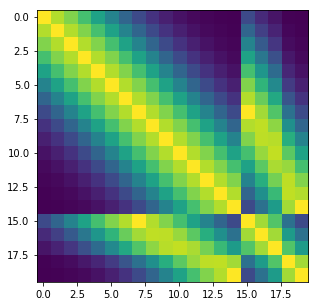

In [12]:
theta = [1, 3, 0.1]
x_new = np.array([0, 1, 2, 4, 5])
K, KS, KSS = get_Ks(x_new, x, kernel, theta)
util.visiualize_Ks(K, KS, KSS)

## Problem 4 - Regression GP (20 pts)

With your posterior covariance matrix $\Sigma$ set up above, you are now ready to run through the regression. What we want to know is the value of $ p(y^{*}|\mathbf{y} )$, which represents how likely a certain prediction for $y^{*}$ is given your data $\mathbf{y} $. 

It turns out this probability is Gaussian distributed:


$$y^{*}|\mathbf{y} \sim \mathcal{N} (K_{*}K^{-1}\mathbf{y}, K_{**} - K_{*}K^{-1}K^{\intercal}_{*})
,$$ 

which makes our best estimate for $y^{*}$ simply the mean of this Gaussian: 


$$\overline{y}_{*} = K_{*}K^{-1}\mathbf{y},$$


Our best estimate of the uncertainty about this value is the variance of this Gaussian: 


$$var(y_{*}) = K_{**} - K_{*}K^{-1}K^{\intercal}_{*}$$


In the cell below, please implement `regression_GP`, which returns the mean and variance estimates of a prediction, according to the equations above. 

In [13]:
def regression_GP(x_new, x, y, kernel, theta):
    K, KS, KSS = get_Ks(x_new, x, kernel, theta)

    y = np.matmul(np.matmul(KS, np.linalg.inv(K)),y)
    var = KSS - KS.dot(np.linalg.inv(K).dot(KS.T))
    var = np.diagonal(var)
    return(y.squeeze(), var.squeeze())

In [14]:
test.test_regression(regression_GP, kernel)

## Problem 5 - Manual Parameter Tuning (5 pts)

# Part 3 - Classification

## Problem 6

Description of a sigmoid function
<center>$S(x)$ = $\dfrac{1}{1+e^{-x}}$</center>
In this PSet use $S(x)$ as the sigmoid functiod in the implementation of the following problems

Implement $S(x)$.

In [27]:
def sigmoid(x):
    return 1./(1+np.exp(-x))

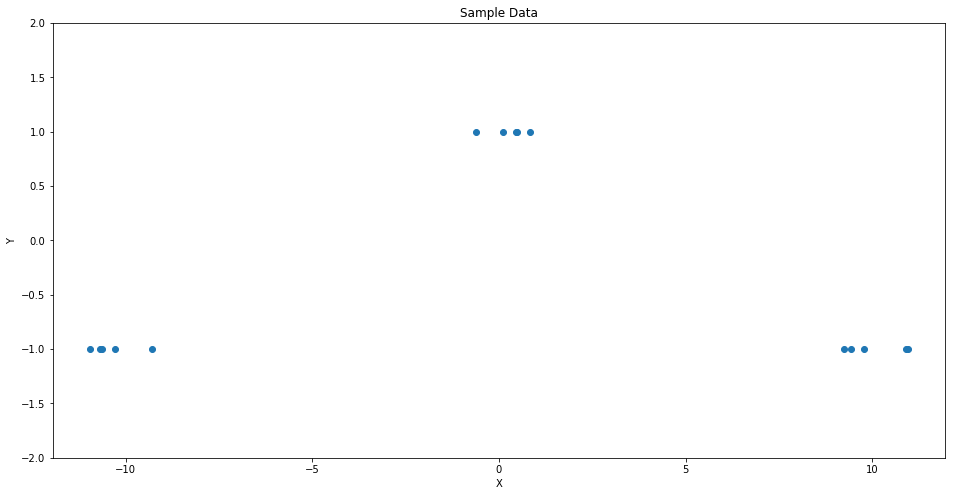

In [28]:
x, y = util.get_sample_classification_data()
util.scatter_raw_data(x, y)

Solve for the covariance matrices K, K$*$, and K$**$ using the function you implemented above

In [35]:
theta = [1, 3, 0]
K, KS, KSS = get_Ks(x, x, kernel, theta)

Find f

In [36]:
def find_f(K, y):
    n = len(y) 
    
    f = np.zeros(n)  
    y_giv_f = np.zeros(n)
    grad = np.zeros(n)
    
    for i in range(0, 100):
        for j in range(n):
            y_giv_f[j] = sigmoid(f[j]*y[j])
            grad[j] = (1-y_giv_f[j])*y[j]
        f = np.array(np.matmul(K, grad)).flatten()
    for j in range(n):
        y_giv_f[j] = sigmoid(f[j]*y[j])
    return f, y_giv_f

Write a function that solves for W given f and y

In [37]:
def calc_W(f, y):
    n = len(y)
    W = np.zeros(n)
    for j in range(n):
        sigmoid_v = sigmoid(f[j]*y[j])
        W[j] = y[j]**2 * (1-sigmoid_v)*sigmoid_v
    return W

Write a function that solves for $K'$

In [38]:
def calculate_KP(K, W):
    return K + (1.0/W)

Now we have all the necessary components. 

In [39]:
def GP(x_new, x, y, kernel, theta):
    K = kernel(x, x, theta[:-1], theta[-1]) # K
    KS = kernel(x_new, x, theta[:-1], theta[-1]) # K*
    KSS = kernel(x_new, x_new, theta[:-1], theta[-1]) # K**
    
    f, y_giv_f = find_f(K, y)
    W = calculate_W(f, y)
    
    KP = calculate_KP(K, W)

    f_bar = np.matmul(np.matmul(KS, np.linalg.inv(K)), f)    
    var = KSS - KS.dot(np.linalg.inv(KP).dot(KS.T))
    var = np.diagonal(var)
    return(f_bar.squeeze(), var.squeeze())

We provided you with $\theta$, now write a function that optimizes $\theta$ for you. Ouput of function is a list.

In [40]:
def optimize_theta(x, y, kernel, params_0=[0.1, 0.1], sigma_n=0.1):
    def log_pY(theta):
        K = np.matrix(kernel(x, x, theta, sigma_n))
        f, y_giv_f = find_f(K, y, 100)
        W = calculate_W(f, y)
        inv_k = np.linalg.inv(K)
        log_k = np.log(np.linalg.det(K) * np.linalg.det(inv_k+W))
        Y_giv_f = np.prod(y_giv_f)
        output = 0.5 * np.matmul(np.matmul(f.T, inv_k),f)
        output += 0.5 * log_k
        output -= np.log(Y_giv_f)
        return output

    res = minimize(log_pY, params_0, method='nelder-mead', options={'xtol': 1e-8, 'disp': False})
    return list(res.x) + [sigma_n]